# Hello World algo-trading

This is a simple momentum based strategy that uses moving averages to find buying and selling opportunities. It consists in using two moving averages with different window sizes, one for shorter term and the other for longer term averages.

The strategy is quite simple. Whenever the short term moving average becomes higher than the long term one, it means that there is momentum and that it is probable that the stock will rise from that point on. Therefore, this crossover of moving averages represents a buying opportunity (long position). The reverse situation on the other hand, that is, when the long term average surpasses the short term one, it means that it is time to sell (short position) since the momentum has started to shift the trend downwards.

This is a very simple strategy based purely on technical analysis. I don't recommend using it on its own for real investing, but it is a great opportunity to introduce oneself in the world of algo-trading.

The code is largely inspired from the DataCamp tutorial ["Python for Finance Tutorial For Beginners"](https://www.datacamp.com/community/tutorials/finance-python-trading). It will serve as the basis for related projects.

In [4]:
# needed imports
import quandl # used to import financial data
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [14]:
SHORT_AVERAGE = 40;
LONG_AVERAGE = 100;

In [15]:
# import AAPL data for testing purposes
aapl = pd.read_csv('data/aapl_ohlc.csv', header=0, index_col='Date', parse_dates=True)

In [33]:
# signals data frame
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0

In [36]:
# Create short simple moving average over the short window. min_periods is used so that no NaN are returned
signals['short_mavg'] = aapl['Close'].rolling(window=SHORT_AVERAGE, min_periods=1, center=False).mean()

In [37]:
# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=LONG_AVERAGE, min_periods=1, center=False).mean()

In [40]:
# signal when the short moving average crosses the long moving average, but only 
# for the period greater than the shortest moving average window

# Create signals
signals['signal'][SHORT_AVERAGE:] = np.where(signals['short_mavg'][SHORT_AVERAGE:]
                                            > signals['long_mavg'][SHORT_AVERAGE:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()


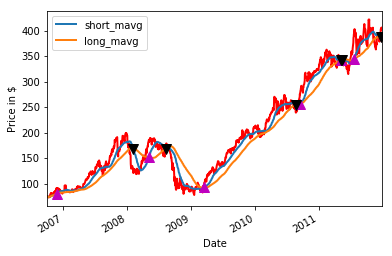

In [41]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

# BackTesting

The prupose of backtesting is to verify the performance of our strategy. However, there are some pitfalls to take into account:
- There are external events, such as market regime shifts, which are regulatory changes or macroeconomic events, which definitely influence your backtesting.
- Liquidity constraints, such as the ban of short sales, could affect your backtesting heavily.
- There are pitfalls which you might introduce yourself when you, for example, overfit a model (optimization bias), when you ignore strategy rules because you think it’s better like that (interference), or when you accidentally introduce information into past data (lookahead bias).

It consists of 4 components:
- A data handler, which is an interface to a set of data,
- A strategy, which generates a signal to go long or go short based on the data,
- A portfolio, which generates orders and manages Profit & Loss (also known as “PnL”), and
- An execution handler, which sends the order to the broker and receives the “fills” or signals that the stock has been bought or sold.

In [47]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj. Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj. Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj. Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head())

            AAPL  holdings      cash     total  returns
Date                                                   
2006-10-02   0.0       0.0  100000.0  100000.0      NaN
2006-10-03   0.0       0.0  100000.0  100000.0      0.0
2006-10-04   0.0       0.0  100000.0  100000.0      0.0
2006-10-05   0.0       0.0  100000.0  100000.0      0.0
2006-10-06   0.0       0.0  100000.0  100000.0      0.0


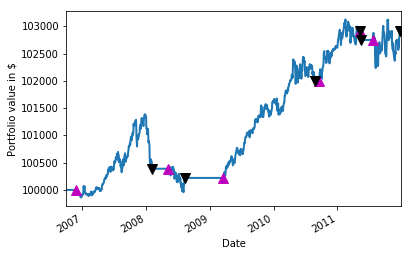

In [48]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

# Evaluating Moving Average Crossover Strategy

**Sharpe Ratio** :  Usually, a ratio greater than 1 is acceptable by investors, 2 is very good and 3 is excellent.

In [49]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.7261238825870339


**Maximum Drawdown**: used to measure the largest single drop from peak to bottom in the value of a portfolio, so before a new peak is achieved. In other words, the score indicates the risk of a portfolio chosen based on a certain strategy.

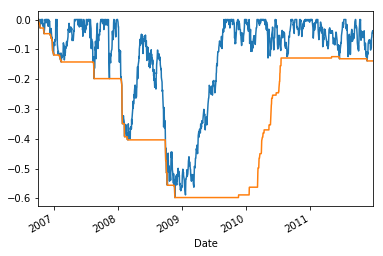

In [51]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = aapl['Adj. Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj. Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

**Compound Annual Growth Rate (CAGR)** : provides a constant rate of return over the time period. In other words, the rate tells you what you really have at the end of your investment period. 

In [53]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj. Close'][-1]) / aapl['Adj. Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.38238012707094704


# Further Improvements


- scikit-Learn, for machine learning based forecasting strategies
- object-oriented structured code
- backtesting with zipline locally
- There are one or more algorithms may be used to improve the model on a continuous basis, such as KMeans, k-Nearest Neighbors (KNN), Classification or Regression Trees and the Genetic Algorithm.
- Working with multi-symbol portfolios. Just incorporating one company or symbol into your strategy often doesn’t really say much.
- Using a risk management framework or use event-driven backtesting to help mitigate the lookahead bias that you read about earlier. 